# AMC + Demodulation Using LSTM Seq2Seq Autoencoder

## Import libraries

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt

import torch

import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from comms import awgn, make_rrc, modulate, demodulate, pulse_shape

## Define baseline

What are we trying to accomplish? QPSK demodulation

In [2]:
def calc_baseline(snr, num_iter=512, M=2, sps = 4, span = 10):
    
    num_weights = sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    ints = np.random.randint(low=0, high=M, size=(num_iter))
    samples = modulate(ints, M=M)
    
    samples = pulse_shape(samples, hrrc, sps=sps)
    samples = awgn(samples, snr, measured=True)

    syms_filtered = np.convolve(samples, hrrc, mode='same')
    extract_symbols = syms_filtered[np.arange(0,len(samples),sps)]
    extract_symbols /= np.sqrt(np.mean(np.abs(extract_symbols)**2)) # normalize to unit power
    
    num_correct = sum(demodulate(extract_symbols, M=M) == ints)
    
    return num_correct/num_iter

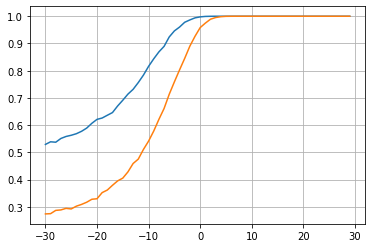

In [3]:
snr_range = np.arange(-30,30)

bpsk_baseline, qpsk_baseline, psk_baseline = [], [], []
for snr in snr_range:
    bpsk_baseline.append(calc_baseline(snr=snr, M=2, num_iter=1024*16))
    qpsk_baseline.append(calc_baseline(snr=snr, M=4, num_iter=1024*16))
#     psk_baseline.append(calc_baseline(snr=snr, M=8, num_iter=2048))

bpsk_baseline = np.array(bpsk_baseline)
qpsk_baseline = np.array(qpsk_baseline)
# psk_baseline = np.array(psk_baseline)
    
plt.plot(snr_range, bpsk_baseline)
plt.plot(snr_range, qpsk_baseline)
# plt.plot(snr_range, psk_baseline)
# plt.plot(snr_range, (bpsk_baseline+qpsk_baseline+psk_baseline)/3, '--')
plt.grid()

## Generate training data

We will need pairs of sequences of pulse shaped symbols and labels. 

E.g. when training for 5 pulse shaped symbols at sps=8, we will have a x_train inputs be of shape batch x 40 x 2, where the last dimension represents real and imaginary channels, and the corresponding y_train will be a sequence of batch x 5, for the 5 classes reprented in 5 pulse shaped symbols taking up 40 samples.

In [4]:
def gen_data(num_examples, seq_length, mod_order=4, sps=4, span=10, snr=50, normalize=True):
    '''
    This function produces a num_examples number of pulse shaped M-QAM waveforms, each
    example is made up from seq_length*sps samples.
    '''
    
    # Calculate number of weights based on sps and span, and create an RRC filter
    num_weights= sps*span+1
    hrrc = make_rrc(num_weights=num_weights, fs=sps)
    
    # Generate random bits
    ints = np.random.randint(low=0, high=mod_order, size=(num_examples * seq_length))
    
    # Modulate according to mod order
    samples = modulate(ints, M=mod_order)
    
    # Pulse shape / upsample the symbols
    samples_pulse_shaped = pulse_shape(samples, hrrc, sps=sps)
    
    # Add noise. IMPORTANT -> measured=True (keep note of this when eveluating)
    samples_noisy = awgn(samples_pulse_shaped, snr, measured=True)
    
    # Reshape the vectors into a new array of shape [num_examples, seq_length]
    data = samples_noisy.reshape(num_examples,-1)
    labels = ints.reshape(num_examples,-1)
    
    # Optionally normalize the waveform (helps with training)
    if normalize:
        data = (data/np.max(np.abs(data),axis=1)[:,None])
    
    return data, labels

def to_tensors(x,y, onehot=False, gpu=False, batch_first=False, normalize=True, num_classes=None):
    '''
    This function takes the outputs from gen_data and does the necessary formatting
    to make the data compatible with torch nn layers.
    '''
    
    # Split complex x into real/imaginary along 3rd axis
    # 2d -> 3d tensor
    x = torch.FloatTensor(np.stack((x.real, x.imag), axis=2))
    
    # One hot encoding if doing MSE/CrossEntropy
    # Otherwise NLLLoss will take the LongTensor
    if onehot:
        y = torch.LongTensor(y)
        if num_classes:
            y = F.one_hot(y, num_classes=num_classes)
        else:
            y = F.one_hot(y, num_classes=len(np.unique(y)))
    else:
        y = torch.LongTensor(y)
        
    # LSTM expects (seq, batch, feats) input shape
    if not batch_first:
        x = x.permute((1,0,2))
        if onehot:
            y = y.permute((1,0,2))
        else:
            y = y.unsqueeze(2).permute((1,0,2))
    
    # Move to cuda device memory if gpu is used
    if gpu:
        x = x.cuda()
        y = y.cuda()
    
    return x,y

Using a GPU greatly helps with training... Transfer data and computation to cuda whenever possible. Here a dataloader is generated for both training and validation losses. Monitor validation to make sure the model is not overfitting.

In [5]:
# # If training on multiple snrs
# datas, labels = [], []

# snrs = np.arange(-10,11,2)
# # snrs = [-10,-5,0]
# for snr in snrs:
#     xt, yt = gen_data(256, 5, sps=8, snr=snr)
#     datas.append(xt)
#     labels.append(yt)
    
# x = np.concatenate((datas))
# y = np.concatenate((labels))
# x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True)

In [6]:
gpu = True

# BPSK will be 0-1, which means qpsk labels need to be offset to 2-5
x_bpsk, y_bpsk = gen_data(1024, 5, mod_order=2, sps=4, snr=5)
x_qpsk, y_qpsk = gen_data(1024, 5, mod_order=4, sps=4, snr=5)
y_qpsk += 2
x = np.concatenate((x_bpsk, x_qpsk))
y = np.concatenate((y_bpsk, y_qpsk))

x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True)

train_dataset = torch.utils.data.TensorDataset(x, y)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

# create validation dataloaders

## bpsk 
x_bpsk, y_bpsk = gen_data(256, 5, mod_order=2, sps=4, snr=5)
x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=gpu, onehot=True, num_classes=6)
val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=32, shuffle=True)

## qpsk 
x_qpsk, y_qpsk = gen_data(256, 5, mod_order=4, sps=4, snr=5)
y_qpsk += 2
x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=gpu, onehot=True, num_classes=6)
val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=32, shuffle=True)

## both

tensor([[1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]], device='cuda:0')


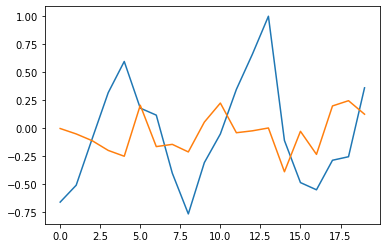

In [7]:
plt.plot(x[1].detach().cpu().numpy())
print(y[1])

Define the encoder and decoder for our autoencoder structure. There's no init function for the decoder as it will only ever be using the one that the encoder provides.

In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_layers = num_layers
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers)

    def forward(self, input, hidden):
        
        output, hidden = self.rnn(input, hidden)
        
        return output, hidden
    
    def initHidden(self, batch_size=32, device='cpu'):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device), 
                torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device))
    
class DecoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, device='cpu'):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size

        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=num_layers)
        self.out = nn.Linear(hidden_size, input_size)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        
#         y = self.out(hidden[0])
        y = self.out(rnn_output)
        
        return y, hidden

## Training

Define the training and validation functions for one epoch.

In [9]:
def train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, teacher_forcing=False, gpu=True, num_classes=6):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # format to (seq x batch x feats) format
    x_train = x_train.permute((1,0,2))
    y_train = y_train.permute((1,0,2))

    loss = 0

    encoder_hidden = encoder.initHidden(batch_size=x_train.shape[1], device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_train, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,x_train.shape[1],num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_train.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_train[i].squeeze().float()) # MSE
        loss += criterion(y.squeeze(), y_train[i].argmax(axis=1)) # cross entropy
#         loss += criterion(F.log_softmax(y.squeeze(),dim=1), y_train[i].argmax(axis=1)) #NLLLoss

        if teacher_forcing:
            decoder_input = y_train[i].float().unsqueeze(0)
        else:
            decoder_input = y

    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    return loss.item()/y_train.shape[0]

def val_step(x_val, y_val, encoder, decoder, criterion, gpu=True, num_classes=6):

    x_val = x_val.permute((1,0,2))
    y_val = y_val.permute((1,0,2))

    loss = 0

    encoder_hidden = encoder.initHidden(batch_size=x_val.shape[1], device = 'cuda' if gpu else 'cpu')
    _, encoder_hidden = encoder(x_val, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_input = torch.zeros((1,x_val.shape[1],num_classes))
    if gpu:
        decoder_input = decoder_input.cuda()

    for i in range(y_val.shape[0]):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
#         loss += criterion(y.squeeze(), y_val[i].squeeze().float()) #mse
        loss += criterion(y.squeeze(), y_val[i].argmax(axis=1)) # cross-entropy
        decoder_input = y
    
    return loss.item()/y_val.shape[0]

def gen_dataset(data_config, train_config):
    
    # if multiple SNR
    if type(data_config['snr']) == np.ndarray:
        datas, labels = [], []
        for sn in data_config['snr']:
            if data_config['num_examples_bpsk'] > 0:
                x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'],
                                data_config['seq_length'],
                                sps=data_config['sps'],
                                mod_order=2,
                                snr=sn)
                datas.append(x_bpsk)
                labels.append(y_bpsk)
            
            if data_config['num_examples_qpsk'] > 0:
                x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'],
                                data_config['seq_length'],
                                sps=data_config['sps'],
                                mod_order=4,
                                snr=sn)
                
                y_qpsk += 2
                
                datas.append(x_qpsk)
                labels.append(y_qpsk)

        x = np.concatenate((datas))
        y = np.concatenate((labels))
    
    # if single SNR
    else:
        x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=2, sps=data_config['sps'], 
                                  snr=data_config['snr'])

        x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'], 
                                  data_config['seq_length'], 
                                  mod_order=4, sps=data_config['sps'], 
                                  snr=data_config['snr'])
        y_qpsk += 2
        x = np.concatenate((x_bpsk, x_qpsk))
        y = np.concatenate((y_bpsk, y_qpsk))

    x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True, num_classes=6)

    train_dataset = torch.utils.data.TensorDataset(x, y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)
    
    return train_dataloader

def inference(x_test, encoder, decoder, num_classes=6, seq_length=5, batch_size=32):
    
    encoder_hidden = encoder.initHidden()

    encoder_hidden = encoder.initHidden(batch_size=batch_size)
    _, encoder_hidden = encoder(x_test, encoder_hidden)

    decoder_hidden = encoder_hidden

    decoder_outputs = torch.zeros((seq_length,batch_size,num_classes))
    decoder_input = torch.zeros((1,batch_size,num_classes))
    
    for i in range(seq_length):
        y, decoder_hidden = decoder(decoder_input, decoder_hidden)
        decoder_outputs[i] = y
        decoder_input = y
        
    return decoder_outputs

def eval_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=4, num_classes=6, batch_size=32):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, seq_length, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes, seq_length=seq_length)

            corrects += torch.sum(y_hat.argmax(axis=2) == y.squeeze())

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

## Train and evaluate

Define a simple evaluation function. Don't forget to load the models back into main memory from cuda.

In [10]:
model_config = {'hidden_size': 16,
                'num_layers': 3,
                'input_size': 2,
                'output_size': 6}

data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

# data_config_bpsk_val = {'snr': np.arange(-5,21,5),
#                         'num_examples_bpsk': 32,
#                         'num_examples_qpsk': 0,
#                         'seq_length': 5,
#                         'sps': 4,
#                         'span': 10,
#                         'num_examples_val': 32}

# data_config_qpsk_val = {'snr': np.arange(-5,21,5),
#                         'num_examples_bpsk': 0,
#                         'num_examples_qpsk': 32,
#                         'seq_length': 5,
#                         'sps': 4,
#                         'span': 10,
#                         'num_examples_val': 32}

train_config = {'num_epochs': 200,
                'batch_size': 64,
                'learning_rate': 0.001,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [11]:
np.random.seed(0)
train_dataloader = gen_dataset(data_config, train_config)

# val_dataloader_bpsk = gen_dataset(data_config_bpsk_val, train_config)
# val_dataloader_qpsk = gen_dataset(data_config_qpsk_val, train_config)

In [12]:
snrs = np.arange(-5,21,5)

## bpsk
datas, labels = [], []
for snr in snrs:
    x_bpsk, y_bpsk = gen_data(32, 5, mod_order=2, sps=4, snr=snr)
    datas.append(x_bpsk)
    labels.append(y_bpsk)
    
x_bpsk = np.concatenate((datas))
y_bpsk = np.concatenate((labels))
x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=gpu, onehot=True, num_classes=6)
val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=32, shuffle=True)

## qpsk
datas, labels = [], []
for snr in snrs:
    x_qpsk, y_qpsk = gen_data(32, 5, mod_order=4, sps=4, snr=snr)
    datas.append(x_qpsk)
    labels.append(y_qpsk)
    
x_qpsk = np.concatenate((datas))
y_qpsk = np.concatenate((labels))

y_qpsk += 2
x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=gpu, onehot=True, num_classes=6)
val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=32, shuffle=True)

0: Best loss 1.1721482038497926, saving...
1: Best loss 0.8220482230186462, saving...
2: Best loss 0.6769174993038177, saving...
3: Best loss 0.5783633579810461, saving...
4: Best loss 0.524771100282669, saving...
5: Best loss 0.47660531749327983, saving...
6: Best loss 0.4520447850227356, saving...
7: Best loss 0.4002118994792302, saving...
9: Best loss 0.34993901699781416, saving...
10: Best loss 0.32635655055443447, saving...
11: Best loss 0.3118946368495623, saving...
12: Best loss 0.3039939671754837, saving...
14: Best loss 0.29027401308218637, saving...
15: Best loss 0.28157962461312613, saving...
16: Best loss 0.2711591159303983, saving...
17: Best loss 0.2632420979440212, saving...
18: Best loss 0.2590340388317903, saving...
19: Best loss 0.2478372101982435, saving...
20: Best loss 0.2418222467104594, saving...
22: Best loss 0.2357805281877518, saving...
23: Best loss 0.23243185281753537, saving...
25: Best loss 0.22676084339618685, saving...
28: Best loss 0.22565395732720694, 

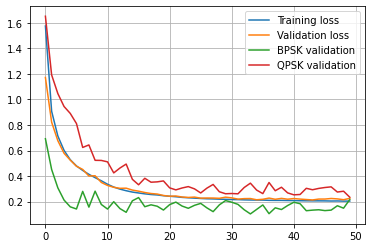

In [13]:
# Loss function - MSE works best for some reason
# criterion = nn.MSELoss()
# criterion = nn.NLLLoss()
criterion = nn.CrossEntropyLoss()

# Create the encoder and decoder models
encoder = EncoderRNN(hidden_size=16, input_size=2, num_layers=3, device = 'cuda' if gpu else 'cpu')
decoder = DecoderRNN(hidden_size=16, input_size=6, num_layers=3, device = 'cuda' if gpu else 'cpu')

encoder.cuda()
decoder.cuda()

# Initialize the optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

# Define empty lists where loss progress will be stored
losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

best_loss = np.inf

# Training loop
for epoch in range(50):
    train_loss = 0
    for x_train,y_train in train_dataloader:
        
        train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                 teacher_forcing=False, gpu=gpu)

    losses.append(train_loss/len(train_dataloader))
    
    with torch.no_grad():
        val_loss = 0
        for x_val,y_val in val_dataloader_bpsk:
            val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
        val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))
        
        val_loss = 0
        for x_val,y_val in val_dataloader_qpsk:
            val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
        val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))
        
        val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
        val_losses.append(val_loss)
        
        if val_loss < best_loss:
            encoder_weights = encoder.state_dict()
            decoder_weights = decoder.state_dict()
            best_loss = val_losses[-1]
            print(f"{epoch}: Best loss {best_loss}, saving...")
        
encoder.load_state_dict(encoder_weights)
decoder.load_state_dict(decoder_weights)
        
plt.plot(losses)
plt.plot(val_losses)
plt.plot(val_losses_bpsk)
plt.plot(val_losses_qpsk)
plt.grid()
plt.legend(('Training loss', 'Validation loss', 'BPSK validation', 'QPSK validation'))

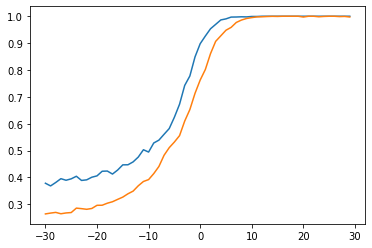

In [14]:
saved = np.load('results/dt_baselines.npz')
plt.plot(saved['snr_range'], saved['bpsk_baseline'])
plt.plot(saved['snr_range'], saved['qpsk_baseline'])

In [15]:
encoder.cpu()
decoder.cpu()

bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)

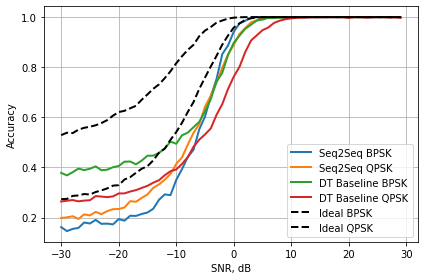

In [16]:
plt.plot(snr_range, bpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, qpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, saved['bpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, saved['qpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, bpsk_baseline, 'k--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, 'k--', linewidth=2)
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.legend(('Seq2Seq BPSK', 'Seq2Seq QPSK', 'DT Baseline BPSK', 'DT Baseline QPSK', 'Ideal BPSK', 'Ideal QPSK'))
plt.tight_layout()

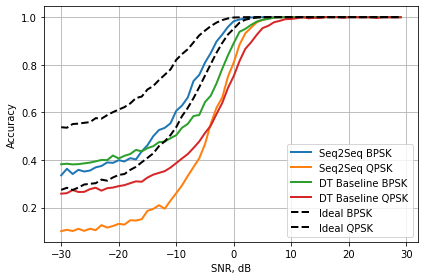

In [16]:
plt.plot(snr_range, bpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, qpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, saved['bpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, saved['qpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, bpsk_baseline, 'k--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, 'k--', linewidth=2)
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.legend(('Seq2Seq BPSK', 'Seq2Seq QPSK', 'DT Baseline BPSK', 'DT Baseline QPSK', 'Ideal BPSK', 'Ideal QPSK'))
plt.tight_layout()

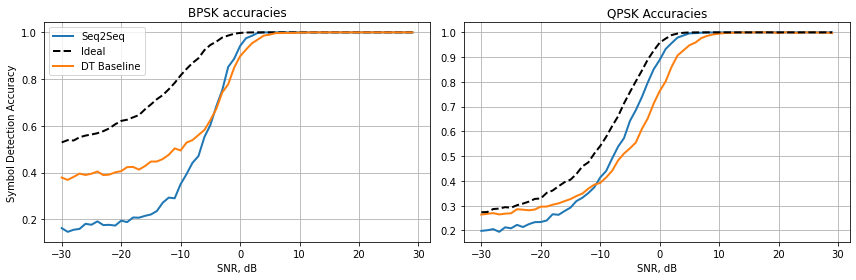

In [17]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(snr_range, np.array(bpsk_accs), '-', linewidth=2)
ax[0].plot(snr_range, np.array(bpsk_baseline), 'k--', linewidth=2)
ax[0].plot(snr_range, saved['bpsk_baseline'], '-', linewidth=2)
ax[0].grid()
ax[0].legend(('Seq2Seq', 'Ideal', 'DT Baseline'))
ax[0].set_xlabel('SNR, dB'); ax[0].set_ylabel('Symbol Detection Accuracy')
ax[0].set_title('BPSK accuracies')


ax[1].plot(snr_range, np.array(qpsk_accs), '-', linewidth=2)
ax[1].plot(snr_range, saved['qpsk_baseline'], '-', linewidth=2)
ax[1].plot(snr_range, np.array(qpsk_baseline), 'k--', linewidth=2)
ax[1].grid()
# ax[1].legend(('Seq2Seq', 'Ideal', 'DT Baseline'))
ax[1].set_xlabel('SNR, dB'); ax[0].set_ylabel('Symbol Detection Accuracy')
ax[1].set_title('QPSK Accuracies')

plt.tight_layout()
# plt.savefig('figures/seq2seq_symbol_detection_accs.png', dpi=300)

## Train data size vs mean accuracy

In [18]:
# 'snr': np.array([-10, -5, 0, 5, 10, 15])
data_config = {'snr': np.arange(-5,21,5),
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

In [19]:
train_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]
model_configs = [(16,3), (128,3)]

for model_config in model_configs:
    for train_size in train_sizes:
        print(train_size)
        data_config['num_examples_bpsk'] = train_size
        data_config['num_examples_qpsk'] = train_size
        
        np.random.seed(0)
        train_dataloader = gen_dataset(data_config, train_config)
        
        criterion = nn.CrossEntropyLoss()

        torch.manual_seed(0)
        
        # Create the encoder and decoder models
        encoder = EncoderRNN(hidden_size=model_config[0], input_size=2, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')
        decoder = DecoderRNN(hidden_size=model_config[0], input_size=6, num_layers=model_config[1], device = 'cuda' if gpu else 'cpu')

        encoder.cuda()
        decoder.cuda()

        # Initialize the optimizers
        encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

        # Define empty lists where loss progress will be stored
        losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

        best_loss = np.inf

        # Training loop
        for epoch in range(100):
            train_loss = 0
            for x_train,y_train in train_dataloader:

                train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                        teacher_forcing=False, gpu=gpu)

            losses.append(train_loss/len(train_dataloader))

            with torch.no_grad():
                val_loss = 0
                for x_val,y_val in val_dataloader_bpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

                val_loss = 0
                for x_val,y_val in val_dataloader_qpsk:
                    val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
                val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

                val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
                val_losses.append(val_loss)

                if val_loss < best_loss:
                    encoder_weights = encoder.state_dict()
                    decoder_weights = decoder.state_dict()
                    best_loss = val_losses[-1]
                    print(f"{epoch}: Best loss {best_loss}, saving...")

        encoder.load_state_dict(encoder_weights)
        decoder.load_state_dict(decoder_weights)
        
        train_results = {'encoder': encoder_weights,
                        'decoder': decoder_weights,
                        'losses': losses,
                        'val_losses': val_losses,
                        'val_losses_bpsk': val_losses_bpsk,
                        'val_losses_qpsk': val_losses_qpsk}
        
        torch.save(train_results, f"models/bpsk_qpsk_seq_{model_config[0]}_{model_config[1]}_{data_config['seq_length']}_trained_on_{train_size}.pt")

128
0: Best loss 1.786861769358317, saving...
1: Best loss 1.778036610285441, saving...
2: Best loss 1.767053667704264, saving...
3: Best loss 1.7527561823527018, saving...
4: Best loss 1.7392305215199788, saving...
5: Best loss 1.7344229459762577, saving...
6: Best loss 1.733222421010335, saving...
7: Best loss 1.7330477396647135, saving...
9: Best loss 1.7329111893971763, saving...
11: Best loss 1.7325324455897013, saving...
12: Best loss 1.7318982839584351, saving...
13: Best loss 1.7310468037923177, saving...
14: Best loss 1.7281328598658243, saving...
15: Best loss 1.7178729454676307, saving...
16: Best loss 1.6966451406478882, saving...
17: Best loss 1.6750149329503377, saving...
18: Best loss 1.6415939887364703, saving...
19: Best loss 1.5900066057840982, saving...
20: Best loss 1.4704585711161293, saving...
21: Best loss 1.3909576177597045, saving...
23: Best loss 1.3330267031987506, saving...
25: Best loss 1.299187994003296, saving...
26: Best loss 1.2924187501271565, saving..

In [21]:
train_size = 8192

data_config['num_examples_bpsk'] = train_size
data_config['num_examples_qpsk'] = train_size

train_dataloader = gen_dataset(data_config, train_config)
val__dataloader = gen_dataset(data_config, train_config)

criterion = nn.CrossEntropyLoss()

torch.manual_seed(0)

# Create the encoder and decoder models
encoder = EncoderRNN(hidden_size=16, input_size=2, num_layers=3, device = 'cuda' if gpu else 'cpu')
decoder = DecoderRNN(hidden_size=16, input_size=6, num_layers=3, device = 'cuda' if gpu else 'cpu')

encoder.cuda()
decoder.cuda()

# Initialize the optimizers
encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

# Define empty lists where loss progress will be stored
losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

best_loss = np.inf

# Training loop
for epoch in range(100):
    train_loss = 0
    for x_train,y_train in train_dataloader:

        train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                 teacher_forcing=False, gpu=gpu)

    losses.append(train_loss/len(train_dataloader))

    with torch.no_grad():
        val_loss = 0
        for x_val,y_val in val_dataloader_bpsk:
            val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
        val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

        val_loss = 0
        for x_val,y_val in val_dataloader_qpsk:
            val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
        val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

        val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
        val_losses.append(val_loss)

        if val_loss < best_loss:
            encoder_weights = encoder.state_dict()
            decoder_weights = decoder.state_dict()
            best_loss = val_losses[-1]
            print(f"{epoch}: Best loss {best_loss}, saving...")

encoder.load_state_dict(encoder_weights)
decoder.load_state_dict(decoder_weights)

train_results = {'encoder': encoder_weights,
                 'decoder': decoder_weights,
                 'losses': losses,
                 'val_losses': val_losses,
                 'val_losses_bpsk': val_losses_bpsk,
                 'val_losses_qpsk': val_losses_qpsk}

torch.save(train_results, f"models/bpsk_qpsk_seq_same_train_and_val_snrs_{train_size}.pt")

0: Best loss 1.1524063800062454, saving...
1: Best loss 0.9600522450038367, saving...
2: Best loss 0.806160511289324, saving...
3: Best loss 0.6746035022394997, saving...
4: Best loss 0.6037874272891453, saving...
5: Best loss 0.5220966777631215, saving...
6: Best loss 0.47223478534391955, saving...
7: Best loss 0.4514331953866141, saving...
8: Best loss 0.44612387589045943, saving...
9: Best loss 0.42753658912011555, saving...
10: Best loss 0.4164416438766888, saving...
11: Best loss 0.41390486125435155, saving...
12: Best loss 0.4105855688452721, saving...
13: Best loss 0.4028578715665, saving...
15: Best loss 0.4023782361830984, saving...
16: Best loss 0.39412600227764677, saving...
18: Best loss 0.39258630403450556, saving...
20: Best loss 0.38726814495665696, saving...
23: Best loss 0.38430789687803824, saving...
24: Best loss 0.381466231388705, saving...
28: Best loss 0.3766764278922762, saving...
31: Best loss 0.3729204784546579, saving...
33: Best loss 0.3717437558940479, savin

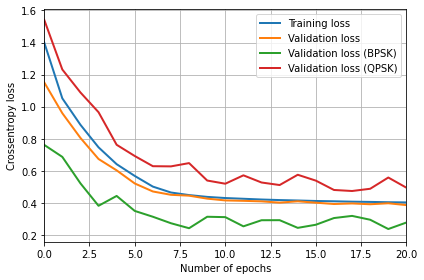

In [22]:
train_result = torch.load(f'models/bpsk_qpsk_seq_same_train_and_val_snrs_{train_size}.pt')
plt.plot(train_result['losses'], linewidth=2)
plt.plot(train_result['val_losses'], linewidth=2)
plt.plot(train_result['val_losses_bpsk'], linewidth=2)
plt.plot(train_result['val_losses_qpsk'], linewidth=2)
plt.xlim([0,20])
# plt.ylim([0,0.2])
plt.grid()
plt.xlabel('Number of epochs'); plt.ylabel('Crossentropy loss')
plt.legend(['Training loss', 'Validation loss', 'Validation loss (BPSK)', 'Validation loss (QPSK)'])
plt.tight_layout()
# plt.savefig('figures/seq2seq_bpsk_qpsk_multivalidation_tracking.png', dpi=300, bbox_inches='tight')

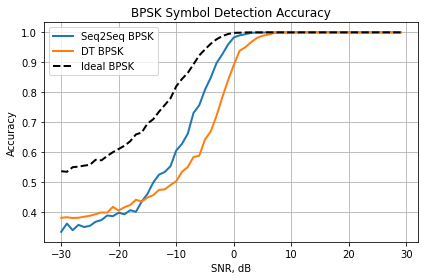

In [24]:
plt.plot(snr_range, bpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, saved['bpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, bpsk_baseline, 'k--', linewidth=2)
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.title('BPSK Symbol Detection Accuracy')
plt.legend(('Seq2Seq BPSK', 'DT BPSK', 'Ideal BPSK'))
plt.grid()
plt.tight_layout()
# plt.savefig('figures/bpsk_demod_accs.png', dpi=300, bbox_inches='tight')

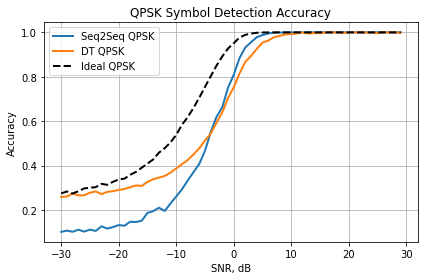

In [25]:
plt.plot(snr_range, qpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, saved['qpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, qpsk_baseline, 'k--', linewidth=2)
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.title('QPSK Symbol Detection Accuracy')
plt.legend(('Seq2Seq QPSK', 'DT QPSK', 'Ideal QPSK'))
plt.grid()
plt.tight_layout()
# plt.savefig('figures/qpsk_demod_accs.png', dpi=300, bbox_inches='tight')

In [26]:
saved = np.load('results/dt_baselines.npz')

In [27]:
saved.files

['bpsk_baseline', 'qpsk_baseline', 'snr_range']

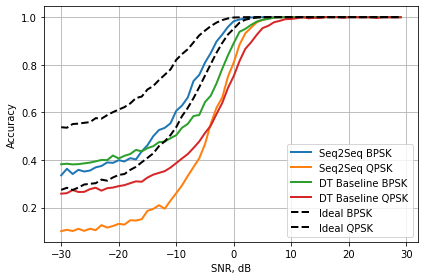

In [29]:
plt.plot(snr_range, bpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, qpsk_accs, linewidth=2, markevery=5)
plt.plot(snr_range, saved['bpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, saved['qpsk_baseline'], linewidth=2, markevery=5)
plt.plot(snr_range, bpsk_baseline, 'k--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, 'k--', linewidth=2)
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')
plt.legend(('Seq2Seq BPSK', 'Seq2Seq QPSK', 'DT Baseline BPSK', 'DT Baseline QPSK', 'Ideal BPSK', 'Ideal QPSK'))
plt.tight_layout()

In [30]:
def eval_mod_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=8, num_classes=6):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, 5, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes)

            if mod_order == 2:
                corrects += torch.sum(y_hat.argmax(axis=2) < 2)
            elif mod_order == 4:
                corrects += torch.sum(sum([y_hat.argmax(axis=2) == val for val in [2,3,4,5]]))
            elif mod_order == 8:
                corrects += torch.sum(y_hat.argmax(axis=2) > 5)

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [31]:
for train_size in train_sizes:
    print(f"Evaling {train_size}")
    # Create the encoder and decoder models
    encoder = EncoderRNN(hidden_size=16, input_size=2, num_layers=3, device = 'cuda' if gpu else 'cpu')
    decoder = DecoderRNN(hidden_size=16, input_size=6, num_layers=3, device = 'cuda' if gpu else 'cpu')
    encoder.cpu()
    decoder.cpu()
    
    model = torch.load(f"models/bpsk_qpsk_seq_{data_config['seq_length']}_trained_on_{train_size}.pt")
    encoder.load_state_dict(model['encoder'])
    decoder.load_state_dict(model['decoder'])
    
    bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
    qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)
    
    bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
    qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)
    
    results = {'snr_range': snr_range,
               'bpsk_accs': bpsk_accs,
               'qpsk_accs': qpsk_accs,
               'bpsk_class_accuracy': bpsk_class_accuracy,
               'qpsk_class_accuracy': qpsk_class_accuracy}
    
    torch.save(results, f"results/bpsk_qpsk_seq_{data_config['seq_length']}_trained_on_{train_size}.pt")

Evaling 128
Evaling 256
Evaling 512
Evaling 1024
Evaling 2048
Evaling 4096
Evaling 8192
Evaling 16384


In [32]:
all_accs = []
train_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 2*8192]
for train_size in train_sizes:
    result = torch.load(f"results/bpsk_qpsk_seq_{data_config['seq_length']}_trained_on_{train_size}.pt")
    all_accs.append((np.array(result['bpsk_accs']) + np.array(result['qpsk_accs']))/2)

In [33]:
np.array(all_accs).mean(axis=1)

array([0.47591634, 0.56955729, 0.65745117, 0.67993164, 0.68777832,
       0.69161133, 0.69380046, 0.69465495])

Text(0, 0.5, 'Average accuracy')

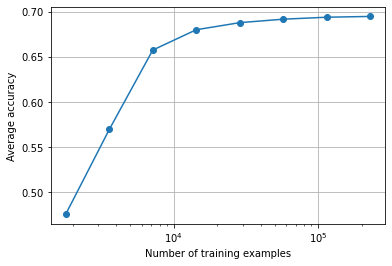

In [34]:
plt.semilogx(np.array(train_sizes)*2*7, np.array(all_accs).mean(axis=1), '-o')
plt.grid()
plt.xlabel('Number of training examples'); plt.ylabel('Average accuracy')

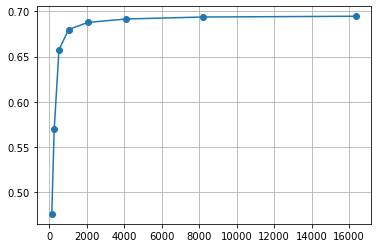

In [35]:
plt.plot(train_sizes, np.mean(all_accs, axis=1), '-o')
plt.grid()

In [36]:
np.array(train_sizes)*2*7

array([  1792,   3584,   7168,  14336,  28672,  57344, 114688, 229376])

In [37]:
bpsk_accs, qpsk_accs = [], []
for train_size in train_sizes:
    result = torch.load(f"results/bpsk_qpsk_seq_{data_config['seq_length']}_trained_on_{train_size}.pt")
    bpsk_accs.append(np.array(result['bpsk_class_accuracy']).mean(axis=0))
    qpsk_accs.append(np.array(result['qpsk_class_accuracy']).mean(axis=0))
#     plt.plot(result['qpsk_class_accuracy'], '--')

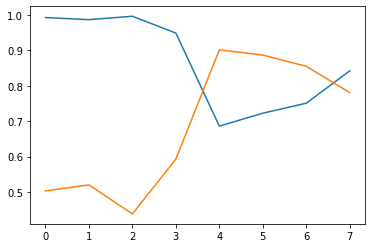

In [38]:
plt.plot(bpsk_accs)
plt.plot(qpsk_accs)

## Training for different sequence lengths

In [8]:
def train_model(model_config, data_config, train_config):
    
    train_dataloader = gen_dataset(data_config, train_config)
    
    ## bpsk
    x_bpsk, y_bpsk = gen_data(num_examples=data_config['num_examples_val'], 
                              seq_length=data_config['seq_length'], 
                              mod_order=2, 
                              sps=data_config['sps'], 
                              snr=data_config['snr_val'])
    
    x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=True, onehot=True, num_classes=6)
    val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=train_config['batch_size'], shuffle=True)

    ## qpsk 
    x_qpsk, y_qpsk = gen_data(num_examples=data_config['num_examples_val'], 
                              seq_length=data_config['seq_length'], 
                              mod_order=4, 
                              sps=data_config['sps'], 
                              snr=data_config['snr_val'])
    y_qpsk += 2
    x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=True, onehot=True, num_classes=6)
    val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=train_config['batch_size'], shuffle=True)

    # Loss function - MSE works best for some reason
#     criterion = nn.MSELoss()
    # criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()

    # Create the encoder and decoder models
    encoder = EncoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['input_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])
    
    decoder = DecoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['output_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])

    encoder.cuda()
    decoder.cuda()
    
    # Initialize the optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])
    
    decoder_optimizer = optim.Adam(decoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])

    # Define empty lists where loss progress will be stored
    losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

    best_loss = np.inf

    # Training loop
    for _ in range(train_config['num_epochs']):
        train_loss = 0
        for x_train,y_train in train_dataloader:

            train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                     teacher_forcing=False)

        losses.append(train_loss/len(train_dataloader))
        
        with torch.no_grad():
            val_loss = 0
            for x_val,y_val in val_dataloader_bpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion)
            val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

            val_loss = 0
            for x_val,y_val in val_dataloader_qpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion)
            val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))
            
            val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
            val_losses.append(val_loss)

            if val_loss < best_loss:
                encoder_weights = encoder.state_dict()
                decoder_weights = decoder.state_dict()
                best_loss = val_losses[-1]
    
    results_dict = {'losses' : losses,
                    'val_losses' : val_losses,
                    'bpsk_losses' : val_losses_bpsk,
                    'qpsk_losses' : val_losses_qpsk,
                    'encoder_weights' : encoder_weights,
                    'decoder_weights' : decoder_weights}
    
    return results_dict

def test_model(encoder, decoder, test_config):
    
    bpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
    qpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)
    
    bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
    qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)
    
    results_dict = {'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accs': bpsk_class_accuracy,
                    'qpsk_class_accs': qpsk_class_accuracy}
    
    return results_dict

In [9]:
model_config = {'hidden_size': 16,
                'num_layers': 3,
                'input_size': 2,
                'output_size': 6}

data_config = {'snr': np.arange(-10,21,5), #np.array([0])
               'num_examples_bpsk': 512,
               'num_examples_qpsk': 512,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256,
               'snr_val': 5}

train_config = {'num_epochs': 200,
                'batch_size': 32,
                'learning_rate': 0.001,
                'weight_decay': 0.0001,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [10]:
seq_lengths = [5, 10, 15, 20]

In [11]:
for seq_length in seq_lengths:
    print(f'Training {seq_length}')
    data_config['seq_length'] = seq_length
    
    all_train_results = []
    for i in range(5):
        print(i)
        torch.manual_seed(i)
        train_results = train_model(model_config, data_config, train_config)
        all_train_results.append(train_results)
    torch.save(all_train_results, f'models/seq2seq_seq_{seq_length}_200_epochs.pt')

Training 5
0
1
2
3
4
Training 10
0
1
2
3
4
Training 15
0
1
2
3
4
Training 20
0
1
2
3
4


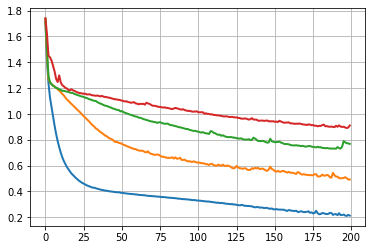

In [16]:
for i, seq_length in enumerate(seq_lengths):
#     plt.figure()
#     for result in torch.load(f"models/seq2seq_seq_{seq_length}_200_epochs.pt"):
#         plt.plot(result['losses'], f'C{i}')
    results = torch.load(f"models/seq2seq_seq_{seq_length}_200_epochs.pt")
    plt.plot(np.mean([result['losses'] for result in results],axis=0), linewidth=2)
plt.grid()

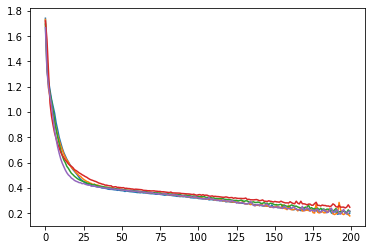

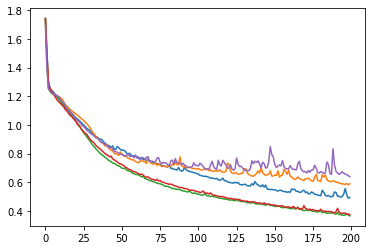

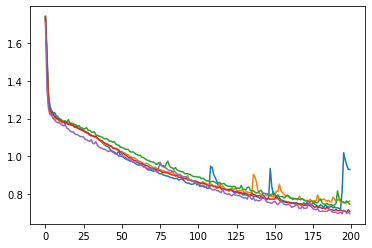

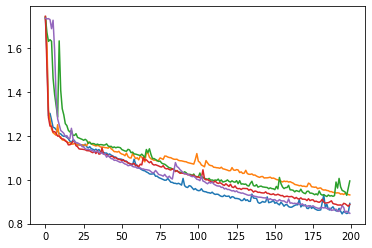

In [14]:
for seq_length in seq_lengths:
    plt.figure()
    for result in torch.load(f"models/seq2seq_seq_{seq_length}_200_epochs.pt"):
        plt.plot(result['losses'])

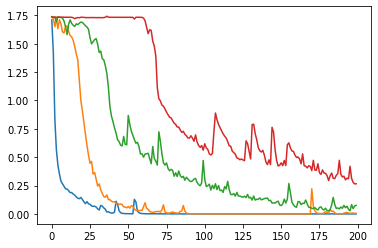

In [63]:
plt.plot(np.array(all_losses).T)

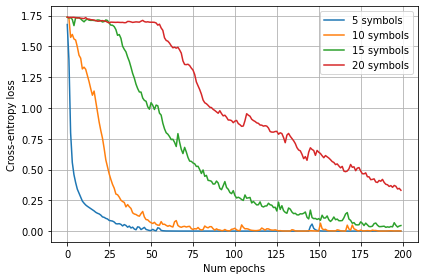

In [72]:
plt.plot(np.array(all_all_losses).mean(axis=0).T)
plt.xlabel('Num epochs'); plt.ylabel('Cross-entropy loss')
plt.legend(('5 symbols', '10 symbols', '15 symbols', '20 symbols'))
plt.grid()
plt.tight_layout()
plt.savefig('figures/losses_per_seq_length.png', dpi=300)

In [12]:
npzfile = np.load('dt_baselines.npz')

In [13]:
sorted(npzfile.files)

['bpsk_baseline', 'qpsk_baseline']

In [14]:
bpsk_baseline_dt = npzfile['bpsk_baseline']
qpsk_baseline_dt = npzfile['qpsk_baseline']

## Train data size vs mean accuracy

In [201]:
# 'snr': np.array([-10, -5, 0, 5, 10, 15])
data_config = {'snr': np.arange(-10,21,5),
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

In [120]:
train_sizes = [128, 256, 512, 1024, 2048, 4096, 8192, 16384]

all_accs = []
all_losses = []
all_val_losses = []

for train_size in train_sizes:
    data_config['num_examples_bpsk'] = train_size
    data_config['num_examples_qpsk'] = train_size
    
    train_dataloader = gen_dataset(data_config, train_config)
    
    criterion = nn.CrossEntropyLoss()

    # Create the encoder and decoder models
    encoder = EncoderRNN(hidden_size=64, input_size=2, num_layers=2, device = 'cuda' if gpu else 'cpu')
    decoder = DecoderRNN(hidden_size=64, input_size=6, num_layers=2, device = 'cuda' if gpu else 'cpu')

    encoder.cuda()
    decoder.cuda()

    # Initialize the optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=3e-4, weight_decay=0.0001)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=3e-4, weight_decay=0.0001)

    # Define empty lists where loss progress will be stored
    losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

    best_loss = np.inf

    # Training loop
    for epoch in range(50):
        train_loss = 0
        for x_train,y_train in train_dataloader:

            train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                     teacher_forcing=False, gpu=gpu)

        losses.append(train_loss/len(train_dataloader))

        best_loss = np.inf

        with torch.no_grad():
            val_loss = 0
            for x_val,y_val in val_dataloader_bpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
            val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

            val_loss = 0
            for x_val,y_val in val_dataloader_qpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
            val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

            val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
            val_losses.append(val_loss)

            if val_loss < best_loss:
                encoder_weights = encoder.state_dict()
                decoder_weights = decoder.state_dict()
                best_loss = val_losses[-1]

    encoder.load_state_dict(encoder_weights)
    decoder.load_state_dict(decoder_weights)
    
    encoder.cpu()
    decoder.cpu()
    
    bpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
    qpsk_accs = eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)
    
    all_accs.append((np.array(bpsk_accs)+np.array(qpsk_accs))/2)
    all_losses.append(losses)
    all_val_losses.append(val_losses)

In [126]:
256*6 

1536

In [125]:
32768*6

196608

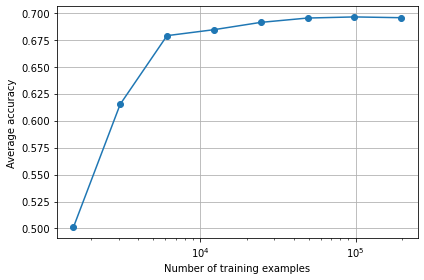

In [124]:
# using SNR=[-10, -5, 0, 5, 10, 15]
plt.semilogx(np.array(train_sizes)*2*6, np.mean(all_accs, axis=1), '-o')
plt.grid()
plt.xlabel('Number of training examples'); plt.ylabel('Average accuracy')
plt.tight_layout()
# plt.savefig('figures/best_train_size_snr.png', dpi=300)

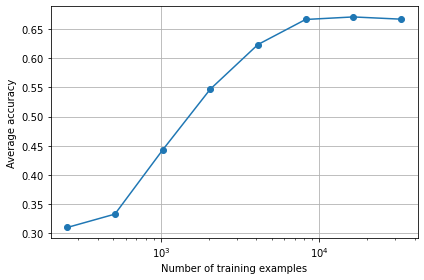

In [101]:
# using SNR=0dB
plt.semilogx(np.array(train_sizes)*2, np.mean(all_accs, axis=1), '-o')
plt.grid()
plt.xlabel('Number of training examples'); plt.ylabel('Average accuracy')
plt.tight_layout()
# plt.savefig('figures/best_train_size.svg', dpi=300)

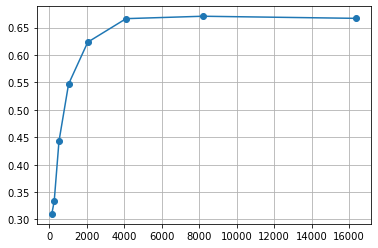

In [93]:
plt.plot(train_sizes, np.mean(all_accs, axis=1), '-o')
plt.grid()

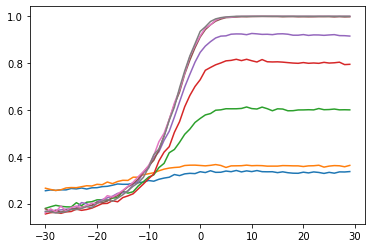

In [94]:
plt.plot(snr_range, np.array(all_accs).T)

Text(0, 0.5, 'Accuracy')

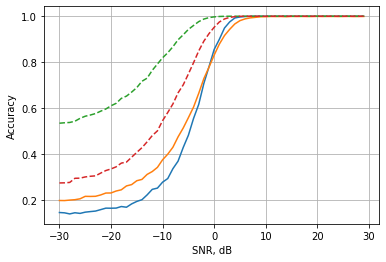

In [13]:
encoder.cpu()
decoder.cpu()

snr_range = np.arange(-30,30)
iters = np.arange(5)

bpsk_accs = np.zeros((len(snr_range),))
qpsk_accs = np.zeros((len(snr_range),))

for i in iters:
    bpsk_accs += eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=2)
    qpsk_accs += eval_accuracy(encoder, decoder, snr_range, num_examples=1024, mod_order=4)

bpsk_accs /= len(iters)
qpsk_accs /= len(iters)

plt.plot(snr_range, bpsk_accs)
plt.plot(snr_range, qpsk_accs)
plt.plot(snr_range, bpsk_baseline, '--')
plt.plot(snr_range, qpsk_baseline, '--')
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Accuracy')

Text(27.0, 0.5, 'Symbol Detection Accuracy')

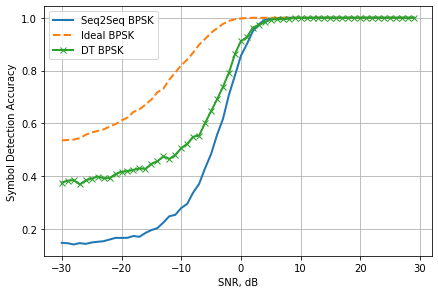

In [17]:
plt.plot(snr_range, np.array(bpsk_accs), '-', linewidth=2)
plt.plot(snr_range, np.array(bpsk_baseline), '--', linewidth=2)
plt.plot(snr_range, np.array(bpsk_baseline_dt), '-x', linewidth=2)
plt.grid()
plt.tight_layout()
plt.legend(('Seq2Seq BPSK', 'Ideal BPSK', 'DT BPSK'))
plt.xlabel('SNR, dB'); plt.ylabel('Symbol Detection Accuracy')

Text(27.0, 0.5, 'Symbol Detection Accuracy')

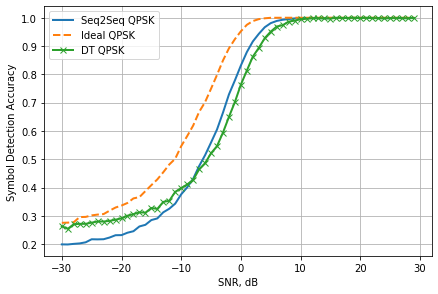

In [18]:
plt.plot(snr_range, np.array(qpsk_accs), '-', linewidth=2)
plt.plot(snr_range, np.array(qpsk_baseline), '--', linewidth=2)
plt.plot(snr_range, np.array(qpsk_baseline_dt), '-x', linewidth=2)
plt.grid()
plt.tight_layout()
plt.legend(('Seq2Seq QPSK', 'Ideal QPSK', 'DT QPSK'))
plt.xlabel('SNR, dB'); plt.ylabel('Symbol Detection Accuracy')

In [20]:
def eval_mod_accuracy(encoder, decoder, snr_range, mod_order=2, num_examples=256, seq_length=5, sps=8, num_classes=6):
    
    accuracies = []
    
    for snr in snr_range:

        x, y = gen_data(num_examples, 5, mod_order=mod_order, sps=sps, snr=snr)
        if mod_order == 4:
            y += 2
        if mod_order == 8:
            y += 6
        x,y = to_tensors(x,y,batch_first=True)

        # create dataset and dataloader
        test_dataset = torch.utils.data.TensorDataset(x, y)
        test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

        corrects, totals = 0, 0
        for x,y in test_dataloader:
            x = x.permute((1,0,2))
            y = y.unsqueeze(2).permute((1,0,2))
            y_hat = inference(x, encoder, decoder, num_classes=num_classes)

            if mod_order == 2:
                corrects += torch.sum(y_hat.argmax(axis=2) < 2)
            elif mod_order == 4:
                corrects += torch.sum(sum([y_hat.argmax(axis=2) == val for val in [2,3,4,5]]))
            elif mod_order == 8:
                corrects += torch.sum(y_hat.argmax(axis=2) > 5)

            totals += y.numel()

        accuracy = np.array(corrects)/totals

        accuracies.append(accuracy)
    
    return accuracies

In [22]:
bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=256, mod_order=2)
qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, snr_range, num_examples=256, mod_order=4)

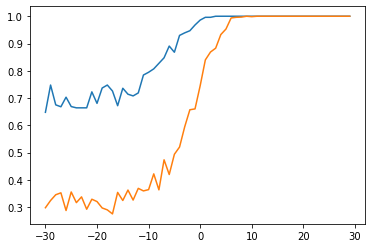

In [23]:
plt.plot(snr_range, bpsk_class_accuracy)
plt.plot(snr_range, qpsk_class_accuracy)

## Class Imbalance

In the previous results we see that there is an imbalance in how the autoencoder performs with the 2 classes. This is because, while both modulation schemes have the same number of examples for classification, the individual symbol representation for learning demodulation is not equal. If the training set has 1024 examples of bpsk and qpsk classes each, that's equal for AMC, however in this case bpsk will have [512, 512] examples for its 2 symbols, whereas QPSK will have [256, 256, 256, 256] for its four symbols.

Most common way of solving this is to upsample the under-represented classes.

In [22]:
def train_model(model_config, data_config, train_config):
    
    train_dataloader = gen_dataset(data_config, train_config)
    
    ## bpsk
    x_bpsk, y_bpsk = gen_data(num_examples=data_config['num_examples_val'], 
                              seq_length=data_config['seq_length'], 
                              mod_order=2, 
                              sps=data_config['sps'], 
                              snr=data_config['snr'])
    
    x_val_bpsk, y_val_bpsk = to_tensors(x_bpsk, y_bpsk, batch_first=True, gpu=True, onehot=True, num_classes=6)
    val_dataloader_bpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_bpsk, y_val_bpsk), batch_size=train_config['batch_size'], shuffle=True)

    ## qpsk 
    x_qpsk, y_qpsk = gen_data(num_examples=data_config['num_examples_val'], 
                              seq_length=data_config['seq_length'], 
                              mod_order=4, 
                              sps=data_config['sps'], 
                              snr=data_config['snr'])
    y_qpsk += 2
    x_val_qpsk, y_val_qpsk = to_tensors(x_qpsk, y_qpsk, batch_first=True, gpu=True, onehot=True, num_classes=6)
    val_dataloader_qpsk = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_val_qpsk, y_val_qpsk), batch_size=train_config['batch_size'], shuffle=True)

    # Loss function - MSE works best for some reason
#     criterion = nn.MSELoss()
    # criterion = nn.NLLLoss()
    criterion = nn.CrossEntropyLoss()

    # Create the encoder and decoder models
    encoder = EncoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['input_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])
    
    decoder = DecoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['output_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])

    encoder.cuda()
    decoder.cuda()
    
    # Initialize the optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])
    
    decoder_optimizer = optim.Adam(decoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])

    # Define empty lists where loss progress will be stored
    losses, val_losses, val_losses_bpsk, val_losses_qpsk = [], [], [], []

    best_loss = np.inf

    # Training loop
    for _ in range(train_config['num_epochs']):
        train_loss = 0
        for x_train,y_train in train_dataloader:

            train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                     teacher_forcing=False)

        losses.append(train_loss/len(train_dataloader))
        
        with torch.no_grad():
            val_loss = 0
            for x_val,y_val in val_dataloader_bpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion)
            val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

            val_loss = 0
            for x_val,y_val in val_dataloader_qpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion)
            val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))
            
            val_loss = (val_losses_bpsk[-1] + val_losses_qpsk[-1])/2
            val_losses.append(val_loss)

            if val_loss < best_loss:
                encoder_weights = encoder.state_dict()
                decoder_weights = decoder.state_dict()
                best_loss = val_losses[-1]
    
    results_dict = {'losses' : losses,
                    'val_losses' : val_losses,
                    'bpsk_losses' : val_losses_bpsk,
                    'qpsk_losses' : val_losses_qpsk,
                    'encoder_weights' : encoder_weights,
                    'decoder_weights' : decoder_weights}
    
    return results_dict

def test_model(encoder, decoder, test_config):
    
    bpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
    qpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)
    
    bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
    qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)
    
    results_dict = {'bpsk_accs': bpsk_accs,
                    'qpsk_accs': qpsk_accs,
                    'bpsk_class_accs': bpsk_class_accuracy,
                    'qpsk_class_accs': qpsk_class_accuracy}
    
    return results_dict

In [ ]:
encoder.load_state_dict(encoder_weights)
decoder.load_state_dict(decoder_weights)

encoder.cpu()
decoder.cpu()

In [26]:
model_config = {'hidden_size': 64,
                'num_layers': 2,
                'input_size': 2,
                'output_size': 6}

data_config = {'snr': np.array([0]),
               'num_examples_bpsk': 1024,
               'num_examples_qpsk': 2048,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

train_config = {'num_epochs': 15,
                'batch_size': 32,
                'learning_rate': 0.001,
                'weight_decay': 0,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [27]:
train_config['num_epochs'] = 50
data_config['num_examples_bpsk'] = 1024+512
data_config['num_examples_qpsk'] = 1024+512

In [122]:
all_losses_equal_dist = []
all_val_losses_equal_dist = []
all_bpsk_losses_equal_dist = []
all_qpsk_losses_equal_dist = []

all_encoder_weights_equal_dist = []
all_decoder_weights_equal_dist = []

for i in range(3):
    train_results = train_model(model_config, data_config, train_config)
    all_losses_equal_dist.append(train_results['losses'])
    all_val_losses_equal_dist.append(train_results['val_losses'])
    all_bpsk_losses_equal_dist.append(train_results['bpsk_losses'])
    all_qpsk_losses_equal_dist.append(train_results['qpsk_losses'])
    
    all_encoder_weights_equal_dist.append(train_results['encoder_weights'])
    all_decoder_weights_equal_dist.append(train_results['decoder_weights'])

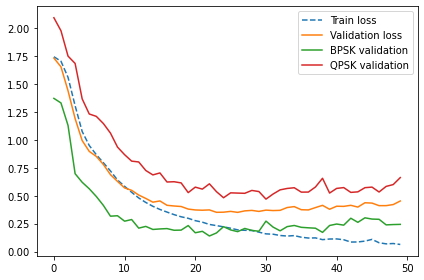

In [123]:
plt.plot(np.mean(np.array(all_losses_equal_dist),axis=0), '--')
plt.plot(np.mean(np.array(all_val_losses_equal_dist),axis=0))
plt.plot(np.mean(np.array(all_bpsk_losses_equal_dist),axis=0))
plt.plot(np.mean(np.array(all_qpsk_losses_equal_dist),axis=0))
plt.legend(('Train loss', 'Validation loss', 'BPSK validation', 'QPSK validation'))
plt.tight_layout()

In [124]:
train_config['num_epochs'] = 50
data_config['num_examples_bpsk'] = 1024
data_config['num_examples_qpsk'] = 2048

In [125]:
all_losses_qpsk_bias = []
all_val_losses_qpsk_bias = []
all_bpsk_losses_qpsk_bias = []
all_qpsk_losses_qpsk_bias = []

all_encoder_weights_qpsk_bias = []
all_decoder_weights_qpsk_bias = []

for i in range(3):
    train_results = train_model(model_config, data_config, train_config)
    all_losses_qpsk_bias.append(train_results['losses'])
    all_val_losses_qpsk_bias.append(train_results['val_losses'])
    all_bpsk_losses_qpsk_bias.append(train_results['bpsk_losses'])
    all_qpsk_losses_qpsk_bias.append(train_results['qpsk_losses'])
    
    all_encoder_weights_qpsk_bias.append(train_results['encoder_weights'])
    all_decoder_weights_qpsk_bias.append(train_results['decoder_weights'])

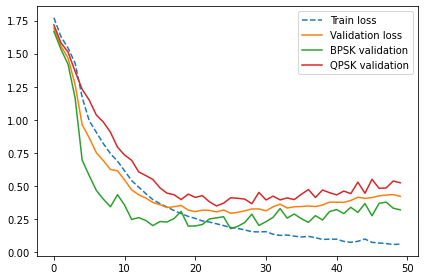

In [126]:
plt.plot(np.mean(np.array(all_losses_qpsk_bias),axis=0), '--')
plt.plot(np.mean(np.array(all_val_losses_qpsk_bias),axis=0))
plt.plot(np.mean(np.array(all_bpsk_losses_qpsk_bias),axis=0))
plt.plot(np.mean(np.array(all_qpsk_losses_qpsk_bias),axis=0))
plt.legend(('Train loss', 'Validation loss', 'BPSK validation', 'QPSK validation'))
plt.tight_layout()

In [131]:
test_config['num_iter'] = 1024

In [132]:
all_bpsk_accs_equal_dist = []
all_qpsk_accs_equal_dist = []
all_bpsk_class_accs_equal_dist = []
all_qpsk_class_accs_equal_dist = []

for encoder_weights, decoder_weights in zip(all_encoder_weights_equal_dist, all_decoder_weights_equal_dist):
    encoder.load_state_dict(encoder_weights)
    decoder.load_state_dict(decoder_weights)
    
    results_dict = test_model(encoder, decoder, test_config)
    
    all_bpsk_accs_equal_dist.append(results_dict['bpsk_accs'])
    all_qpsk_accs_equal_dist.append(results_dict['qpsk_accs'])
    all_bpsk_class_accs_equal_dist.append(results_dict['bpsk_class_accs'])
    all_qpsk_class_accs_equal_dist.append(results_dict['qpsk_class_accs'])

In [133]:
all_bpsk_accs_qpsk_bias = []
all_qpsk_accs_qpsk_bias = []
all_bpsk_class_accs_qpsk_bias = []
all_qpsk_class_accs_qpsk_bias = []

for encoder_weights, decoder_weights in zip(all_encoder_weights_qpsk_bias, all_decoder_weights_qpsk_bias):
    encoder.load_state_dict(encoder_weights)
    decoder.load_state_dict(decoder_weights)
    
    results_dict = test_model(encoder, decoder, test_config)
    
    all_bpsk_accs_qpsk_bias.append(results_dict['bpsk_accs'])
    all_qpsk_accs_qpsk_bias.append(results_dict['qpsk_accs'])
    all_bpsk_class_accs_qpsk_bias.append(results_dict['bpsk_class_accs'])
    all_qpsk_class_accs_qpsk_bias.append(results_dict['qpsk_class_accs'])

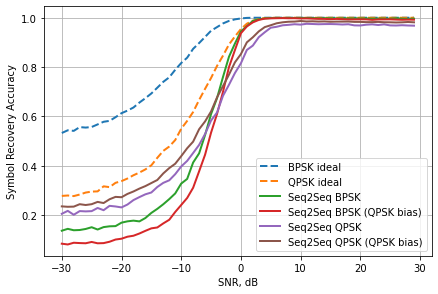

In [141]:
plt.plot(snr_range, bpsk_baseline, '--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, '--', linewidth=2)
plt.plot(snr_range, np.mean(np.array(all_bpsk_accs_equal_dist),axis=0), linewidth=2)
plt.plot(snr_range, np.mean(np.array(all_bpsk_accs_qpsk_bias),axis=0), linewidth=2)
plt.plot(snr_range, np.mean(np.array(all_qpsk_accs_equal_dist),axis=0), linewidth=2)
plt.plot(snr_range, np.mean(np.array(all_qpsk_accs_qpsk_bias),axis=0), linewidth=2)
plt.legend(('BPSK ideal', 'QPSK ideal', 'Seq2Seq BPSK', 'Seq2Seq BPSK (QPSK bias)', 'Seq2Seq QPSK', 'Seq2Seq QPSK (QPSK bias)'))
plt.tight_layout()
plt.grid()
plt.xlabel('SNR, dB');plt.ylabel('Symbol Recovery Accuracy')
plt.savefig('figures/demod_accuracy_qpsk_bias.png', dpi=300)

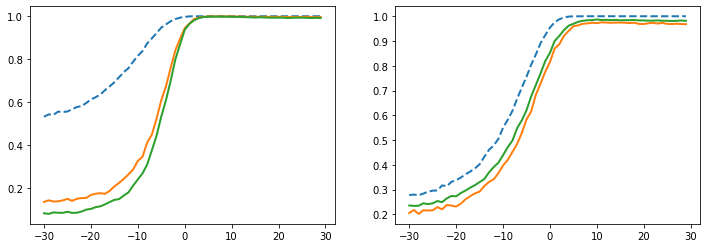

In [143]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].plot(snr_range, bpsk_baseline, '--', linewidth=2)
ax[1].plot(snr_range, qpsk_baseline, '--', linewidth=2)
ax[0].plot(snr_range, np.mean(np.array(all_bpsk_accs_equal_dist),axis=0), linewidth=2)
ax[0].plot(snr_range, np.mean(np.array(all_bpsk_accs_qpsk_bias),axis=0), linewidth=2)
ax[1].plot(snr_range, np.mean(np.array(all_qpsk_accs_equal_dist),axis=0), linewidth=2)
ax[1].plot(snr_range, np.mean(np.array(all_qpsk_accs_qpsk_bias),axis=0), linewidth=2)
# ax[0].legend(('BPSK ideal', 'QPSK ideal', 'Seq2Seq BPSK', 'Seq2Seq BPSK (QPSK bias)', 'Seq2Seq QPSK', 'Seq2Seq QPSK (QPSK bias)'))
# ax[0].tight_layout()
# ax[0].grid()
# ax[0].xlabel('SNR, dB');plt.ylabel('Symbol Recovery Accuracy')
# ax[0].savefig('figures/demod_accuracy_qpsk_bias.png', dpi=300)

## Training for different sequence lengths

In [56]:
model_config = {'hidden_size': 256,
                'num_layers': 2,
                'input_size': 2,
                'output_size': 6}

data_config = {'snr': np.array([0]),
               'num_examples_bpsk': 4096,
               'num_examples_qpsk': 4096,
               'seq_length': 5,
               'sps': 4,
               'span': 10,
               'num_examples_val': 256}

train_config = {'num_epochs': 200,
                'batch_size': 64,
                'learning_rate': 0.001,
                'weight_decay': 0,
                'device': 'cuda',
                'teacher_forcing': False}

test_config = {'snr_range': np.arange(-30,30),
               'num_iter': 1024}

In [57]:
seq_lengths = [5, 10, 15, 20]

In [60]:
all_all_losses = []
for i in range(5):
    
    all_losses = []
    for seq_length in seq_lengths:
        data_config['seq_length'] = seq_length

        train_results = train_model(model_config, data_config, train_config)

        all_losses.append(train_results['losses'])
    all_all_losses.append(all_losses)

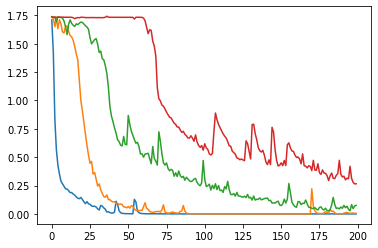

In [63]:
plt.plot(np.array(all_losses).T)

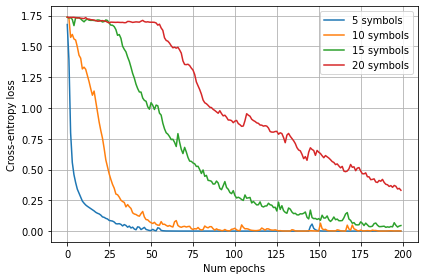

In [72]:
plt.plot(np.array(all_all_losses).mean(axis=0).T)
plt.xlabel('Num epochs'); plt.ylabel('Cross-entropy loss')
plt.legend(('5 symbols', '10 symbols', '15 symbols', '20 symbols'))
plt.grid()
plt.tight_layout()
plt.savefig('figures/losses_per_seq_length.png', dpi=300)

## Train on more snr data for better DT comparison

In [56]:
data_config['num_examples_bpsk'] = 1024
data_config['num_examples_qpsk'] = 1024
results_equal_dist = train_and_evaluate(model_config, data_config, train_config, test_config)

In [57]:
data_config['num_examples_bpsk'] = 1024
data_config['num_examples_qpsk'] = 2048
results_qpsk_bias = train_and_evaluate(model_config, data_config, train_config, test_config)

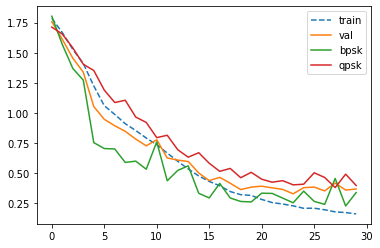

In [58]:
# plt.plot(results_equal_dist['losses'])
plt.plot(results_qpsk_bias['losses'], '--')
plt.plot(results_qpsk_bias['val_losses'])

# plt.plot(results_equal_dist['bpsk_losses'])
plt.plot(results_qpsk_bias['bpsk_losses'])

# plt.plot(results_equal_dist['qpsk_losses'])
plt.plot(results_qpsk_bias['qpsk_losses'])
plt.legend(('train', 'val', 'bpsk', 'qpsk'))

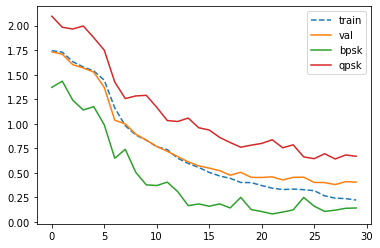

In [59]:
plt.plot(results_equal_dist['losses'], '--')
# plt.plot(results_qpsk_bias['losses'])
plt.plot(results_equal_dist['val_losses'])

plt.plot(results_equal_dist['bpsk_losses'])
# plt.plot(results_qpsk_bias['bpsk_losses'])

plt.plot(results_equal_dist['qpsk_losses'])
# plt.plot(results_qpsk_bias['qpsk_losses'])
plt.legend(('train', 'val', 'bpsk', 'qpsk'))

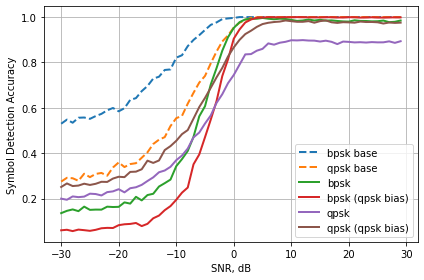

In [52]:
plt.plot(snr_range, bpsk_baseline, '--', linewidth=2)
plt.plot(snr_range, qpsk_baseline, '--', linewidth=2)
plt.plot(snr_range, results_equal_dist['bpsk_accs'], linewidth=2)
plt.plot(snr_range, results_qpsk_bias['bpsk_accs'], linewidth=2)
plt.plot(snr_range, results_equal_dist['qpsk_accs'], linewidth=2)
plt.plot(snr_range, results_qpsk_bias['qpsk_accs'], linewidth=2)
plt.legend(('bpsk base', 'qpsk base', 'bpsk', 'bpsk (qpsk bias)', 'qpsk', 'qpsk (qpsk bias)'))
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Symbol Detection Accuracy')
plt.tight_layout()

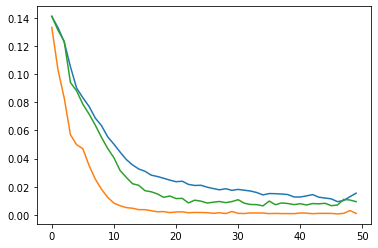

In [51]:
# plt.plot(results_equal_dist['losses'])
plt.plot(results_qpsk_bias['losses'])

# plt.plot(results_equal_dist['bpsk_losses'])
plt.plot(results_qpsk_bias['bpsk_losses'])

# plt.plot(results_equal_dist['qpsk_losses'])
plt.plot(results_qpsk_bias['qpsk_losses'])

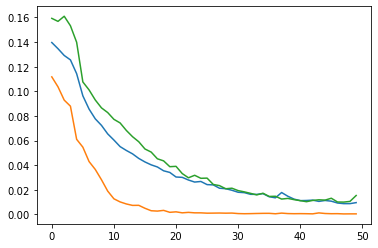

In [52]:
plt.plot(results_equal_dist['losses'])
# plt.plot(results_qpsk_bias['losses'])

plt.plot(results_equal_dist['bpsk_losses'])
# plt.plot(results_qpsk_bias['bpsk_losses'])

plt.plot(results_equal_dist['qpsk_losses'])
# plt.plot(results_qpsk_bias['qpsk_losses'])

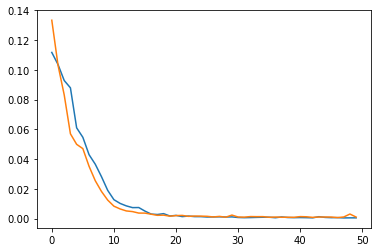

In [41]:
plt.plot(results_equal_dist['bpsk_losses'])
plt.plot(results_qpsk_bias['bpsk_losses'])

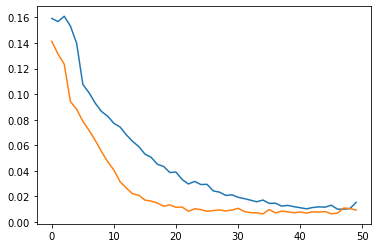

In [42]:
plt.plot(results_equal_dist['qpsk_losses'])
plt.plot(results_qpsk_bias['qpsk_losses'])

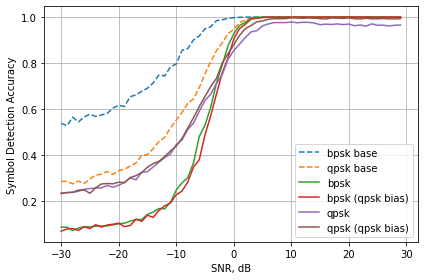

In [34]:
plt.plot(snr_range, bpsk_baseline, '--')
plt.plot(snr_range, qpsk_baseline, '--')
plt.plot(snr_range, results_equal_dist['bpsk_accs'])
plt.plot(snr_range, results_qpsk_bias['bpsk_accs'])
plt.plot(snr_range, results_equal_dist['qpsk_accs'])
plt.plot(snr_range, results_qpsk_bias['qpsk_accs'])
plt.legend(('bpsk base', 'qpsk base', 'bpsk', 'bpsk (qpsk bias)', 'qpsk', 'qpsk (qpsk bias)'))
plt.grid()
plt.xlabel('SNR, dB'); plt.ylabel('Symbol Detection Accuracy')
plt.tight_layout()

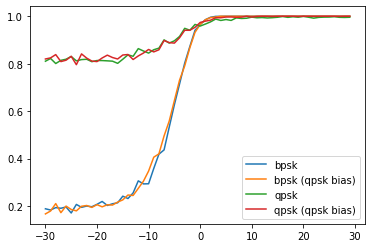

In [87]:
plt.plot(snr_range, results_equal_dist['bpsk_class_accs'])
plt.plot(snr_range, results_qpsk_bias['bpsk_class_accs'])
plt.plot(snr_range, results_equal_dist['qpsk_class_accs'])
plt.plot(snr_range, results_qpsk_bias['qpsk_class_accs'])
plt.legend(('bpsk', 'bpsk (qpsk bias)', 'qpsk', 'qpsk (qpsk bias)'))

In [44]:
def train_model(model_config, data_config, train_config):
    
    x_bpsk, y_bpsk = gen_data(data_config['num_examples_bpsk'], 
                              data_config['seq_length'], 
                              mod_order=2, sps=data_config['sps'], 
                              snr=data_config['snr'])
    
    x_qpsk, y_qpsk = gen_data(data_config['num_examples_qpsk'], 
                              data_config['seq_length'], 
                              mod_order=4, sps=data_config['sps'], 
                              snr=data_config['snr'])
    y_qpsk += 2
    x = np.concatenate((x_bpsk, x_qpsk))
    y = np.concatenate((y_bpsk, y_qpsk))

    x, y = to_tensors(x, y, batch_first=True, gpu=True, onehot=True)

    train_dataset = torch.utils.data.TensorDataset(x, y)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True)


    # Loss function - MSE works best for some reason
    criterion = nn.MSELoss()
    # criterion = nn.NLLLoss()
    # criterion = nn.CrossEntropyLoss()

    # Create the encoder and decoder models
    encoder = EncoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['input_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])
    
    decoder = DecoderRNN(hidden_size = model_config['hidden_size'], 
                         input_size = model_config['output_size'],
                         num_layers = model_config['num_layers'], 
                         device = train_config['device'])

    # Initialize the optimizers
    encoder_optimizer = optim.Adam(encoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])
    
    decoder_optimizer = optim.Adam(decoder.parameters(), 
                                   lr=train_config['learning_rate'], 
                                   weight_decay=train_config['weight_decay'])

    # Define empty lists where loss progress will be stored
    losses, val_losses_bpsk, val_losses_qpsk = [], [], []

    best_loss = np.inf

    # Training loop
    for _ in range(train_config['num_epochs']):
        train_loss = 0
        for x_train,y_train in train_dataloader:

            train_loss += train_step(x_train, y_train, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, 
                                     teacher_forcing=False, gpu=gpu)

        losses.append(train_loss/len(train_dataloader))

        with torch.no_grad():
            val_loss = 0
            for x_val,y_val in val_dataloader_bpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
            val_losses_bpsk.append(val_loss/len(val_dataloader_bpsk))

            val_loss = 0
            for x_val,y_val in val_dataloader_qpsk:
                val_loss += val_step(x_val, y_val, encoder, decoder, criterion, gpu=gpu)
            val_losses_qpsk.append(val_loss/len(val_dataloader_qpsk))

    losses_dict = {'losses' : losses,
                    'bpsk_losses' : val_losses_bpsk,
                    'qpsk_losses' : val_losses_qpsk}
    
    return encoder, decoder, losses_dict

In [45]:
encoder, decoder, losses_dict = train_model(model_config, data_config, train_config)

In [ ]:
def eval_seq_lengths(encoder, decoder, snr_range, seq_lengths):
        encoder.cpu()
        decoder.cpu()

        for length in seq_lengths:
            
            bpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
            qpsk_accs = eval_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)

#             bpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=2)
#             qpsk_class_accuracy = eval_mod_accuracy(encoder, decoder, test_config['snr_range'], num_examples=test_config['num_iter'], mod_order=4)

        
        
        results_dict = {'losses' : losses,
                        'bpsk_losses' : val_losses_bpsk,
                        'qpsk_losses' : val_losses_qpsk,
                        'bpsk_accs': bpsk_accs,
                        'qpsk_accs': qpsk_accs,
                        'bpsk_class_accs': bpsk_class_accuracy,
                        'qpsk_class_accs': qpsk_class_accuracy}

In [ ]:
seq_lengths = np.arange(5,50,5)

qpsk_class_accs = []

for length in seq_lengths:
    accuracies_qpsk = []

    for snr in snr_range:
        x_test, y_test = gen_mod_data(512, length, mod_order=4, sps=4, span=10, snr=snr)

        num_correct = 0

        for idx, x in enumerate(x_test):
            y_hat = classify_demodulate(x)
            num_correct += np.sum(y_hat==y_test[idx])

        accuracies_qpsk.append(num_correct/y_test.size)
    qpsk_class_accs.append(np.mean(accuracies_qpsk))